In [1670]:
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn import set_config

set_config(transform_output="pandas")

df = pd.read_csv('data/train_set.csv')
df_test = pd.read_csv('data/test_set.csv')

submit = True
make_grid_search = False

In [1671]:
# Feature engineering
# ----

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, PolynomialFeatures


class RenovationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Initialize any parameters you need here
        pass
    
    def fit(self, X, y=None):
        # Fit the transformer to the data (e.g. compute any necessary statistics)
        return self
    
    def get_renovated_years_ago(self, yearRemodAdd, yearBuilt):
      if(yearRemodAdd == yearBuilt):
         return 0
      else:
         return 2025 - yearRemodAdd

    def transform(self, X):
        # Create the custom features
        X['IsRenovated'] = X["YearBuilt"] < X["YearRemodAdd"]
        X['YearsSinceRenovation'] = X.apply(lambda x: self.get_renovated_years_ago(x.YearRemodAdd, x.YearBuilt), axis=1)
        
        return X
    

class OverallQualTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Initialize any parameters you need here
        pass
    
    def fit(self, X, y=None):
        # Fit the transformer to the data (e.g. compute any necessary statistics)
        return self
    
    def transform(self, X):
      polynomial_transform =  PolynomialFeatures(degree=2, include_bias=False)
      results = polynomial_transform.fit_transform(X[["OverallQual"]])
      X['OverallQual^2'] = results["OverallQual^2"]
      X["AggregatedQual"] = X["OverallQual^2"] * X["KitchenQual"] * X["ExterQual"]
        
      return X

class GarageAreaTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Initialize any parameters you need here
        pass
    
    def fit(self, X, y=None):
        # Fit the transformer to the data (e.g. compute any necessary statistics)
        return self
    
    def transform(self, X):
      X['HasGarage'] = X["GarageArea"] > 0
        
      return X
    
class NeighborhoodTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Initialize any parameters you need here
        pass
    
    def fit(self, X, y=None):
        # Fit the transformer to the data (e.g. compute any necessary statistics)
        return self
    
    def transform(self, X):
      polynomial_transform =  PolynomialFeatures(degree=3, include_bias=False)
      results = polynomial_transform.fit_transform(X[["Neighborhood"]])
      X['Neighborhood^2'] = results["Neighborhood^2"]
      X['Neighborhood^3'] = results["Neighborhood^3"]
        
      return X
    

class PolynomialSquaredTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Initialize any parameters you need here
        pass
    
    def fit(self, X, y=None):
        # Fit the transformer to the data (e.g. compute any necessary statistics)
        return self
    
    def transform(self, X):
      polynomial_transform =  PolynomialFeatures(degree=2, include_bias=False)
      results = polynomial_transform.fit_transform(X[["TotalBsmtSF"]])
      X['TotalBsmtSF^2'] = results["TotalBsmtSF^2"]
      results = polynomial_transform.fit_transform(X[["TotRmsAbvGrd"]])
      X['TotRmsAbvGrd^2'] = results["TotRmsAbvGrd^2"]
        
      return X
    
# ----
# ----


In [1672]:
# fig, axs = plt.subplots(1, 2, figsize=(15, 4))
# sns.boxplot(df, x="GarageArea", ax=axs[0])
# sns.scatterplot(df, x="GarageArea", y="SalePrice", ax=axs[1])
# fig.tight_layout()
# plt.show()

# fig, axs = plt.subplots(1, 2, figsize=(15, 4))
# sns.boxplot(df, x="TotalBsmtSF", ax=axs[0])
# sns.scatterplot(df, x="TotalBsmtSF", y="SalePrice", ax=axs[1])
# axs[1].set_title('Prix fonction de la superficie du sous-sol')

In [1673]:
# fig, axs = plt.subplots(3, 3, figsize=(15, 10))
# sns.histplot(df, x="GrLivArea", bins=30, ax=axs[0, 0])
# axs[0, 0].set_title('Surface habitable hors sous-sol')
# sns.histplot(df, x="TotalBsmtSF", bins=30, ax=axs[0, 1])
# axs[0, 1].set_title('Superficie totale du sous-sol')
# sns.histplot(df, x="1stFlrSF", bins=30, ax=axs[0, 2])
# axs[0, 2].set_title('Superficie du rez-de-chaussée')
# sns.histplot(df, x="YearBuilt", bins=30, ax=axs[1, 0])
# axs[1, 0].set_title('Année de construction')
# sns.histplot(df, x="YearRemodAdd", bins=30, ax=axs[1, 1])
# axs[1, 1].set_title('Année de rénovation')
# sns.histplot(df, x="GarageArea", bins=30, ax=axs[1, 2])
# axs[1, 2].set_title('Taille du garage en pieds carrés')
# sns.histplot(df, x="LotArea", bins=30, ax=axs[2, 0])
# axs[2, 0].set_title('Surface totale du terrain')
# sns.histplot(df, x="TotRmsAbvGrd", bins=14, ax=axs[2, 1])
# axs[2, 1].set_title('Nombre total de pièces au-dessus du sol')
# fig.tight_layout()

### Preprocessing

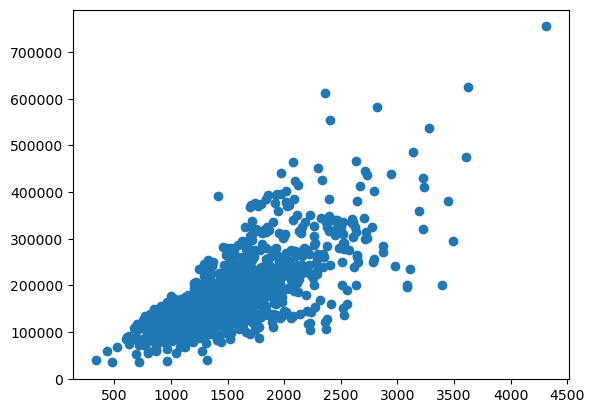

In [1674]:
# Outliers removal
# ----

# remove outliers according to GrLivArea
from sklearn.neighbors import LocalOutlierFactor

# remove outlier on TotalBsmtSF
df = df.query('TotalBsmtSF < 5000 & LotArea < 150000')

detection_model = LocalOutlierFactor(n_neighbors=5, contamination=0.01)
outliers = detection_model.fit_predict(df[["GrLivArea", "SalePrice"]])

df = df[outliers == 1].sort_values(by=['GrLivArea'])
plt.scatter(df["GrLivArea"], df["SalePrice"])
plt.show()

# fig, axs = plt.subplots(1, 2, figsize=(12, 4))                 
# sns.boxplot(df, x="GrLivArea", ax=axs[0])
# sns.scatterplot(df, x="GrLivArea", y="SalePrice", ax=axs[1])
# fig.tight_layout()  

# # Filtering rows where series_filter is -1
# df = df[outliers == 1].sort_values(by=['GrLivArea'])

# # remove outliers according to LotArea

# detection_model = LocalOutlierFactor(n_neighbors=30, contamination=0.01)
# outliers = detection_model.fit_predict(df[["LotArea", "SalePrice"]])
# # plt.scatter(df["LotArea"], df["SalePrice"], c=outliers, cmap="bwr_r")
# # plt.show()

# # Filtering rows where series_filter is -1
# df = df[outliers == 1].sort_values(by=['LotArea'])

#X_train = X_train.query('GarageArea < 1200 & TotalBsmtSF < 2300')
#y_train = df["SalePrice"]


# ----
# ----

In [1675]:
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

# Preprocessing for numerical data


### Ordinal encoding ---

qual_order = ["Po", "Fa", "TA", "Gd", "Ex"]

# We order neighboorhood by average saleprice to attribute it a value
results = df.groupby(['Neighborhood']).agg({'SalePrice': ['mean']}).reset_index()
results.columns = ['Neighborhood', 'SalePrice']
results = results.sort_values(by=['SalePrice']).reset_index()
neighborhood_order = results['Neighborhood']

ordinal_encoder_transformer = Pipeline(steps=[
   ("OrdinalEncoder", OrdinalEncoder(categories=[qual_order, qual_order, neighborhood_order])),
   ("scaler", MinMaxScaler())
])

qual_columns_transformer = ColumnTransformer(transformers=[
   ("Ordinal Transform", ordinal_encoder_transformer, ["ExterQual", "KitchenQual", "Neighborhood"]),
],
remainder="passthrough",
verbose_feature_names_out=False)

# exterQual_pipeline = Pipeline(steps=[
#    ('Transform ExterQual', qual_columns_transformer)
# ])
# X_train = exterQual_pipeline.fit_transform(X_train)
# X_train["ExterQual"].unique()

### --- encoding

columns_transformer = ColumnTransformer(transformers=[
   ("Min-max Scaler", MinMaxScaler(), ["YearBuilt", "YearRemodAdd", "OverallQual", "GarageCars", "FullBath", "YearsSinceRenovation", "Fireplaces"]),
   ("Standard Scaler", StandardScaler(), ["GrLivArea", "1stFlrSF", "LotArea", "TotRmsAbvGrd", "GarageArea"])
],
remainder="passthrough",
verbose_feature_names_out=False)




In [1676]:
from sklearn.model_selection import train_test_split

pipeline = Pipeline(steps=[
   ('Transform ExterQual + KitchenQual', qual_columns_transformer),
   ('Renovation year Feature Engineering', RenovationTransformer()),
   ('Overall Qual Polynomial Feature Engineering ', OverallQualTransformer()),
   ('HasGarage Feature Engineering', GarageAreaTransformer()),
   ('TotalBsmtSFTransformer', PolynomialSquaredTransformer()),
   ('Neighborhood Feature Engineering', NeighborhoodTransformer()),
   ("Transform other columns", columns_transformer)])




### Training

In [1677]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

predictio_colmuns = [
   "LotArea", 
   "GrLivArea", 
   "OverallQual", 
   "OverallQual^2",
   #"AggregatedQual",
   #"YearBuilt", 
   "FullBath", 
   "TotalBsmtSF",
   #"TotalBsmtSF^2",
   #"HasGarage",
   "TotRmsAbvGrd", 
   "TotRmsAbvGrd^2",
   #"ExterQual", 
   "KitchenQual",
   #"YearsSinceRenovation",
   "YearRemodAdd",
   #"IsRenovated",
   "Neighborhood", 
   #"Neighborhood^2", 
   #"Neighborhood^3", 
   #"Fireplaces"
]

#model = LinearRegression()
model = RandomForestRegressor(criterion="squared_error", n_estimators=150)

if(submit == False & make_grid_search == False):
   mae_list = []
   for i in range(5):
      X_train, X_test, y_train, y_test = train_test_split(df, df["SalePrice"], test_size=0.2)
      
      X_train = pipeline.fit_transform(X_train.drop("SalePrice", axis=1))
      X_train = X_train[predictio_colmuns]
      X_test = pipeline.transform(X_test)

      model.fit(X_train, y_train)
      predictions = model.predict(X_test[predictio_colmuns])

      # plot histogram of the difference between predictions and expected values
      differences = predictions - y_test
      #print(differences.head())
      # fix, axs = plt.subplots(1, 2, figsize=(10, 4))
      # sns.histplot(differences, bins=30, ax=axs[0])
      # sns.boxplot(differences, orient="h", ax=axs[1])
      # plt.show()

      # compute mean absolute error
      mae_list.append(mean_absolute_error(predictions, y_test))
      
   print(mae_list)
   print(f"MAE = {np.mean(mae_list)}")


if(make_grid_search == True):
   model = RandomForestRegressor(criterion="squared_error", n_estimators=150)

   param_grid_random_forest = {
      "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
      "n_estimators": [100, 150, 200, 300]
   }


   grid_search = GridSearchCV(estimator=model, param_grid=param_grid_random_forest, cv=5, scoring="neg_mean_absolute_error")
   grid_search.fit(X_train, y_train)
   params = grid_search.cv_results_["params"]
   scores = grid_search.cv_results_["mean_test_score"]
   grid_search_results = pd.DataFrame(params)
   grid_search_results["score"] = scores
   grid_search_results
   grid_search_heatmap = grid_search_results.pivot(index='n_estimators', columns='criterion', values="score")
   sns.heatmap(grid_search_heatmap, annot=True, fmt=".3f", cmap="viridis")
   plt.show()
   print(f"Meilleurs paramètres : {grid_search.best_params_}")
   print(f"Meilleurs score : {grid_search.best_score_}")

In [1678]:
if(submit == True):
   X_train = df
   y_train = df["SalePrice"]
   X_test = df_test

   X_train = pipeline.fit_transform(X_train.drop("SalePrice", axis=1))
   X_train = X_train[predictio_colmuns]
   X_test = pipeline.transform(X_test)

   model.fit(X_train, y_train)
   predictions = model.predict(X_test[predictio_colmuns])

   submissions = pd.DataFrame()
   submissions["SalePrice"] = predictions
   submissions.index.name = "ID"
   submissions
   submissions.to_csv("submission.csv")

   

In [1679]:
type(differences)
indices = differences[differences < -100000]
indices.index.values
outliers = df.iloc[indices.index.values]
outliers




,OverallQual,GrLivArea,TotalBsmtSF,1stFlrSF,YearBuilt,YearRemodAdd,GarageCars,GarageArea,FullBath,TotRmsAbvGrd,KitchenQual,Fireplaces,LotArea,Neighborhood,ExterQual,SalePrice
359,6,1888,1517,1888,1966,2002,2,578,2,6,Gd,1,16492,NAmes,Gd,190000
290,5,1505,883,988,1940,1982,1,240,1,8,TA,0,9144,BrkSide,TA,145000
